### This notebook generate the line benefits from the operational cost

In [406]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [407]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [408]:
#%% Setting up the path a cases
DirName  = os.getcwd()

# CSV_name =  'OC_fy_1'
# CSV_name =  'OC_fy_2'
# CSV_name =  'OC_fy_3'
CSV_name =  'OC_fy_4'

CaseName_Base     = '9n'
CaseName_ByStages = CaseName_Base + '_ByStages_' + CSV_name

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [409]:
df_1 = pd.read_csv(_path_0+'/3.Out/Estimations/'+'Estimated_'+CSV_name+'.csv', index_col=0)

In [410]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [411]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [412]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_6_cac1,Network_Line_In_Node_1_Node_6_cac2,Network_Line_In_Node_1_Node_6_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Network_Line_In_Node_2_Node_6_cac1,Network_Line_In_Node_2_Node_6_cac2,Network_Line_In_Node_2_Node_6_cac3,Network_Line_In_Node_3_Node_4_cac1,...,Network_Line_In_Node_6_Node_7_cac3,Network_Line_In_Node_6_Node_8_cac1,Network_Line_In_Node_6_Node_8_cac2,Network_Line_In_Node_6_Node_8_cac3,Network_Line_In_Node_7_Node_8_cac1,Network_Line_In_Node_7_Node_8_cac2,Network_Line_In_Node_7_Node_8_cac3,Network_Line_In_Node_8_Node_9_cac1,Network_Line_In_Node_8_Node_9_cac2,Network_Line_In_Node_8_Node_9_cac3
0,-0.000289,-0.000621,-0.000996,0.000157,0.000181,0.000181,0.000204,0.000327,0.000449,0.000228,...,0.000932,-0.000212,-0.000174,-0.000278,0.000381,0.000714,0.000897,-0.000041,-0.000251,-0.000484
1,-0.000217,-0.000576,-0.000935,0.000141,0.000166,0.000178,0.000265,0.000388,0.000511,0.000367,...,0.000992,-0.000106,-0.000096,-0.000244,0.000436,0.000648,0.000831,-0.000094,-0.000327,-0.000486
2,-0.000335,-0.000575,-0.000928,0.000148,0.000241,0.000264,0.000265,0.000398,0.000527,0.000243,...,0.000958,-0.000195,-0.000214,-0.000212,0.000360,0.000778,0.000965,-0.000016,-0.000228,-0.000457
3,-0.000335,-0.000557,-0.000929,0.000073,0.000270,0.000323,0.000258,0.000368,0.000501,0.000184,...,0.000799,-0.000249,-0.000412,-0.000236,0.000346,0.000743,0.001042,-0.000070,-0.000183,-0.000408
4,-0.000329,-0.000530,-0.000897,0.000070,0.000320,0.000366,0.000228,0.000362,0.000484,0.000161,...,0.000732,-0.000276,-0.000362,-0.000277,0.000316,0.000683,0.001136,-0.000101,-0.000158,-0.000384


In [413]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [414]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_6_cac1,Network_Line_In_Node_1_Node_6_cac2,Network_Line_In_Node_1_Node_6_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Network_Line_In_Node_2_Node_6_cac1,Network_Line_In_Node_2_Node_6_cac2,Network_Line_In_Node_2_Node_6_cac3,Network_Line_In_Node_3_Node_4_cac1,...,Network_Line_In_Node_6_Node_7_cac3,Network_Line_In_Node_6_Node_8_cac1,Network_Line_In_Node_6_Node_8_cac2,Network_Line_In_Node_6_Node_8_cac3,Network_Line_In_Node_7_Node_8_cac1,Network_Line_In_Node_7_Node_8_cac2,Network_Line_In_Node_7_Node_8_cac3,Network_Line_In_Node_8_Node_9_cac1,Network_Line_In_Node_8_Node_9_cac2,Network_Line_In_Node_8_Node_9_cac3
LoadLevel,,,,,,,,,,,,,,,,,,,,,
01-01 00:00:00+01:00,-0.000289,-0.000621,-0.000996,0.000157,0.000181,0.000181,0.000204,0.000327,0.000449,0.000228,...,0.000932,-0.000212,-0.000174,-0.000278,0.000381,0.000714,0.000897,-0.000041,-0.000251,-0.000484
01-01 01:00:00+01:00,-0.000217,-0.000576,-0.000935,0.000141,0.000166,0.000178,0.000265,0.000388,0.000511,0.000367,...,0.000992,-0.000106,-0.000096,-0.000244,0.000436,0.000648,0.000831,-0.000094,-0.000327,-0.000486
01-01 02:00:00+01:00,-0.000335,-0.000575,-0.000928,0.000148,0.000241,0.000264,0.000265,0.000398,0.000527,0.000243,...,0.000958,-0.000195,-0.000214,-0.000212,0.000360,0.000778,0.000965,-0.000016,-0.000228,-0.000457
01-01 03:00:00+01:00,-0.000335,-0.000557,-0.000929,0.000073,0.000270,0.000323,0.000258,0.000368,0.000501,0.000184,...,0.000799,-0.000249,-0.000412,-0.000236,0.000346,0.000743,0.001042,-0.000070,-0.000183,-0.000408
01-01 04:00:00+01:00,-0.000329,-0.000530,-0.000897,0.000070,0.000320,0.000366,0.000228,0.000362,0.000484,0.000161,...,0.000732,-0.000276,-0.000362,-0.000277,0.000316,0.000683,0.001136,-0.000101,-0.000158,-0.000384


In [415]:
ddf_1 = diff_df_1.stack()

In [416]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [417]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [418]:
ddf_1.head()

Value
LoadLevel            Execution                                   
01-01 00:00:00+01:00 Network_Line_In_Node_1_Node_6_cac1 -0.000289
                     Network_Line_In_Node_1_Node_6_cac2 -0.000621
                     Network_Line_In_Node_1_Node_6_cac3 -0.000996
                     Network_Line_In_Node_2_Node_3_cac1  0.000157
                     Network_Line_In_Node_2_Node_3_cac2  0.000181

In [419]:
ddf_1 = ddf_1.reset_index()

In [420]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [421]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [422]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
314491,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac2,0.000617,1900-12-30 23:00:00
314492,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac3,0.000976,1900-12-30 23:00:00
314493,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac1,-0.000156,1900-12-30 23:00:00
314494,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac2,-0.000236,1900-12-30 23:00:00
314495,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac3,-0.000396,1900-12-30 23:00:00


#### Getting day of year and month

In [423]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [424]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac1,-0.000289,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac2,-0.000621,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac3,-0.000996,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000157,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000181,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [425]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [426]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
314491,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac2,0.000617,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_7_Node_8_cac2_23
314492,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac3,0.000976,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_7_Node_8_cac3_23
314493,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac1,-0.000156,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac1_23
314494,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac2,-0.000236,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac2_23
314495,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac3,-0.000396,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac3_23


In [427]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [428]:
table.tail()

Variable   Network_Line_In_Node_1_Node_6_cac1_0  \
Month Day                                         
12    360                             -0.000880   
      361                             -0.000331   
      362                             -0.000377   
      363                             -0.000430   
      364                             -0.000329   

Variable   Network_Line_In_Node_1_Node_6_cac1_1  \
Month Day                                         
12    360                              0.000000   
      361                             -0.000331   
      362                             -0.000343   
      363                             -0.000397   
      364                             -0.000334   

Variable   Network_Line_In_Node_1_Node_6_cac1_10  \
Month Day                                          
12    360                              -0.000472   
      361                              -0.000365   
      362                              -0.003477   
      363                              -0.003477   
      364                              -0.000928   

Variable   Network_Line_In_Node_1_Node_6_cac1_11  \
Month Day                                          
12    360                              -0.000464   
      361                              -0.000362   
      362                              -0.003498   
      363                              -0.003477   
      364                              -0.003498   

Variable   Network_Line_In_Node_1_Node_6_cac1_12  \
Month Day                                          
12    360                              -0.000279   
      361                              -0.000390   
      362                              -0.003477   
      363                              -0.001594   
      364                              -0.000351   

Variable   Network_Line_In_Node_1_Node_6_cac1_13  \
Month Day                                          
12    360                              -0.000385   
      361                              -0.000294   
      362                              -0.003498   
      363                              -0.000868   
      364                              -0.000456   

Variable   Network_Line_In_Node_1_Node_6_cac1_14  \
Month Day                                          
12    360                              -0.000268   
      361                              -0.000311   
      362                              -0.000909   
      363                              -0.000400   
      364                              -0.000267   

Variable   Network_Line_In_Node_1_Node_6_cac1_15  \
Month Day                                          
12    360                              -0.000298   
      361                              -0.000327   
      362                              -0.000416   
      363                              -0.000391   
      364                              -0.000410   

Variable   Network_Line_In_Node_1_Node_6_cac1_16  \
Month Day                                          
12    360                              -0.000317   
      361                              -0.000350   
      362                              -0.000318   
      363                              -0.000273   
      364                              -0.000341   

Variable   Network_Line_In_Node_1_Node_6_cac1_17  ...  \
Month Day                                         ...   
12    360                              -0.000317  ...   
      361                              -0.000350  ...   
      362                              -0.000294  ...   
      363                              -0.000316  ...   
      364                              -0.000318  ...   

Variable   Network_Line_In_Node_8_Node_9_cac3_21  \
Month Day                                          
12    360                              -0.000538   
      361                              -0.000603   
      362                               0.008203   
      363                               0.007334   
      364        

In [429]:
table = table.reset_index()

In [430]:
table = table.set_index(['Day'])

In [431]:
table.tail()

Variable,Month,Network_Line_In_Node_1_Node_6_cac1_0,Network_Line_In_Node_1_Node_6_cac1_1,Network_Line_In_Node_1_Node_6_cac1_10,Network_Line_In_Node_1_Node_6_cac1_11,Network_Line_In_Node_1_Node_6_cac1_12,Network_Line_In_Node_1_Node_6_cac1_13,Network_Line_In_Node_1_Node_6_cac1_14,Network_Line_In_Node_1_Node_6_cac1_15,Network_Line_In_Node_1_Node_6_cac1_16,...,Network_Line_In_Node_8_Node_9_cac3_21,Network_Line_In_Node_8_Node_9_cac3_22,Network_Line_In_Node_8_Node_9_cac3_23,Network_Line_In_Node_8_Node_9_cac3_3,Network_Line_In_Node_8_Node_9_cac3_4,Network_Line_In_Node_8_Node_9_cac3_5,Network_Line_In_Node_8_Node_9_cac3_6,Network_Line_In_Node_8_Node_9_cac3_7,Network_Line_In_Node_8_Node_9_cac3_8,Network_Line_In_Node_8_Node_9_cac3_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,-0.000880,0.000000,-0.000472,-0.000464,-0.000279,-0.000385,-0.000268,-0.000298,-0.000317,...,-0.000538,-0.000535,-0.000522,-0.000980,-0.000439,-0.000414,-0.000674,-0.000465,-0.000559,-0.000611
361,12,-0.000331,-0.000331,-0.000365,-0.000362,-0.000390,-0.000294,-0.000311,-0.000327,-0.000350,...,-0.000603,-0.000612,-0.000774,-0.000334,-0.000320,-0.000211,-0.000177,-0.000183,-0.000524,-0.000441
362,12,-0.000377,-0.000343,-0.003477,-0.003498,-0.003477,-0.003498,-0.000909,-0.000416,-0.000318,...,0.008203,-0.000575,-0.000586,-0.000520,-0.000522,-0.000485,-0.000446,-0.000499,-0.000662,-0.000599
363,12,-0.000430,-0.000397,-0.003477,-0.003477,-0.001594,-0.000868,-0.000400,-0.000391,-0.000273,...,0.007334,-0.000364,-0.000370,-0.000661,-0.000657,-0.000678,-0.000678,-0.000736,-0.000578,-0.000606
364,12,-0.000329,-0.000334,-0.000928,-0.003498,-0.000351,-0.000456,-0.000267,-0.000410,-0.000341,...,0.007982,-0.000488,-0.000396,-0.000334,-0.000334,-0.000342,-0.000373,-0.000428,-0.000765,-0.000720


#### Split data table into data X and class labels y

In [432]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [433]:
print(X)
print(y)

[[-2.891500e-04 -2.165500e-04 -6.691564e-04 ... -3.613600e-04
  -4.511770e-04 -9.254740e-04]
 [-3.309200e-04 -3.309200e-04 -3.573480e-03 ... -7.263540e-04
  -5.274720e-04  3.087851e-03]
 [-2.015150e-04 -3.632980e-04 -5.735887e-04 ... -4.397110e-04
   6.218600e-05  4.255250e-04]
 ...
 [-3.771330e-04 -3.433900e-04 -3.477150e-03 ... -4.994740e-04
  -6.622650e-04 -5.991950e-04]
 [-4.304500e-04 -3.971860e-04 -3.477194e-03 ... -7.355000e-04
  -5.775390e-04 -6.056920e-04]
 [-3.292150e-04 -3.340150e-04 -9.281300e-04 ... -4.281650e-04
  -7.652540e-04 -7.197370e-04]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  

## PCA step by step

#### Standardizing of the data

In [434]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [435]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-6.32141040e-03+0.j          6.61312739e-03+0.j
  -6.24798466e-02+0.j         ...  1.71352750e-02-0.00060874j
   1.71352750e-02+0.00060874j  7.46098429e-05+0.j        ]
 [-5.68859276e-03+0.j          9.29879513e-03+0.j
  -6.14214242e-02+0.j         ...  1.47946061e-02+0.00126344j
   1.47946061e-02-0.00126344j -1.26989952e-02+0.j        ]
 [-4.00197753e-02+0.j          5.94362894e-02+0.j
   8.59464758e-03+0.j         ... -1.29534755e-02-0.00012467j
  -1.29534755e-02+0.00012467j  1.26857469e-02+0.j        ]
 ...
 [ 3.65009329e-02+0.j          6.36099602e-02+0.j
  -1.19408988e-02+0.j         ... -3.73706338e-02-0.00406579j
  -3.73706338e-02+0.00406579j  2.16574156e-02+0.j        ]
 [ 4.26262062e-02+0.j         -1.41775364e-02+0.j
   9.26955715e-04+0.j         ... -1.46630581e-02+0.00144363j
  -1.46630581e-02-0.00144363j  3.60825518e-02+0.j        ]
 [ 4.18895052e-02+0.j         -4.01441084e-02+0.j
  -8.59201409e-03+0.j         ... -4.07102567e-02-0.00222194j
  -4.07102567e

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [436]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [437]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
366.41868753114966
61.09745786622837
52.8847636607917
46.685809352693006
34.98937017978533
24.909768374104917
23.03121911872128
20.716220307168168
18.780989822542832
17.888046581888425
14.276027746878817
12.973719608103698
10.357906913067387
9.95821694040062
9.0134063015458
8.381367420252895
8.064053527899041
6.802872555866573
6.525867907124971
5.785993291688712
5.746222044404997
5.039097016799765
4.724536524937568
4.183282113571635
4.10247684493589
3.938685159805935
3.8958952213089373
3.522100876413569
2.9589745746806138
2.8817625533128775
2.727493565882122
2.3368418586581727
2.2304644316035014
2.1862013017758266
2.0174223678869545
1.869946152990554
1.8334509102210186
1.7590245754270573
1.681058579792514
1.6329252245983477
1.5798366467543299
1.5249723193772897
1.474693364753615
1.3465873061018445
1.2805162667749308
1.235346515200421
1.1890733039385333
1.1403150715538488
1.0995936664086179
1.081405984919394
0.9952290759194405
0.9928882943536111
0.938080

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [438]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [439]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

(42.29306050754452+0j) 0
(49.34509843662497+0j) 1
(55.44920443761302+0j) 2
(60.83780995088745+0j) 3
(64.8763800361229+0j) 4
(67.75153454358883+0j) 5
(70.40986168927456+0j) 6
(72.80098525571167+0j) 7
(74.96873915578767+0j) 8
(77.03342707208088+0j) 9
(78.68120576310302+0j) 10
(80.17866843917574+0j) 11
(81.37420676381053+0j) 12
(82.52361176399032+0j) 13
(83.56396410152756+0j) 14
(84.53136475958101+0j) 15
(85.4621401686887+0j) 16
(86.24734657442346+0j) 17
(87.00058033583421+0j) 18
(87.66841571844098+0j) 19
(88.33166059345339+0j) 20
(88.91328713786042+0j) 21
(89.45860623843797+0j) 22
(89.94145225467554+0j) 23
(90.41497150284141+0j) 24
(90.86958546073262+0j) 25
(91.3192604853228+0j) 26
(91.72579113058956+0j) 27
(92.06732417730845+0j) 28
(92.39994519851463+0j) 29
(92.71476006560839+0j) 30
(92.98448482989566+0j) 31
(93.24193121670888+0j) 32
(93.49426863039446+0j) 33
(93.72712511173062+0j) 34
(93.94295947958761+0j) 35
(94.1545814653713+0j) 36
(94.35761295730761+0j) 37
(94.55164539793155+0j) 38


Then

c:\Users\erik_\miniconda3\Lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


c:\Users\erik_\miniconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


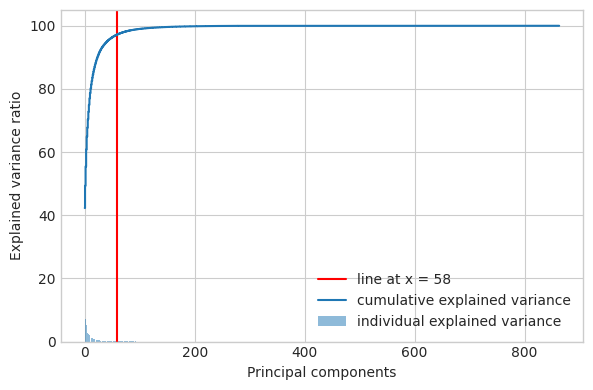

In [440]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [441]:
labels = np.unique(y, axis=0)

In [442]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

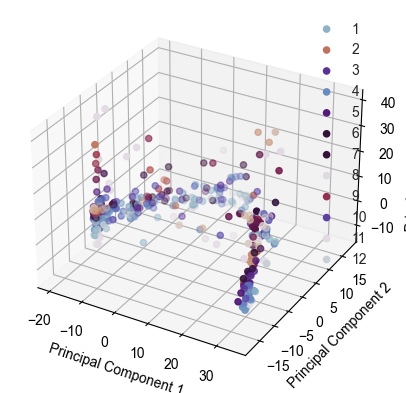

In [443]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

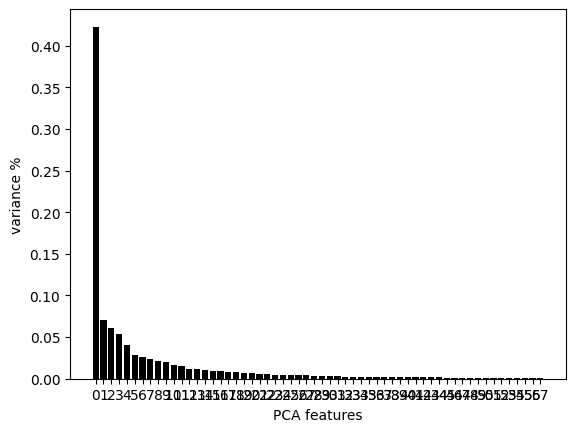

In [444]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [445]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [446]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,-19.319821,-5.858130,-7.323743,1.522766,1.467232,-1.234457,2.489838,-0.194578,1.746852,0.009286,...,-1.305744,-0.701444,0.251037,0.442580,0.916931,0.806110,-0.297661,-0.664732,-0.880168,1.074952
1,5.166386,10.779319,-2.401756,-4.737941,-2.861302,-4.203503,-1.422302,-3.550114,-6.265276,4.392923,...,0.228671,0.140260,-0.270198,-2.011925,-0.225057,0.160482,-0.399332,1.222182,-0.164543,-0.316156
2,-8.229169,3.051764,-6.924855,-14.692252,4.609895,-8.939973,-1.782154,0.622011,-2.017001,0.110302,...,-1.460623,-1.472500,-0.922403,-0.631590,-0.194880,-0.205667,0.536217,0.290853,2.307183,-0.352945
3,-11.136472,-0.551679,-0.465058,-7.818143,3.400108,-6.787778,-2.323774,-2.758874,-1.403285,1.297732,...,0.459935,1.364895,0.096754,-0.480415,0.626910,0.941071,-0.417789,1.130472,0.506545,-0.553708
4,2.841162,14.013114,-1.677285,5.631839,-3.841970,-0.350504,-4.250943,-2.526654,-7.239003,5.826173,...,-0.509211,0.771538,0.578721,-0.151969,0.009751,-2.384006,0.042603,0.713710,0.200520,0.867541


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

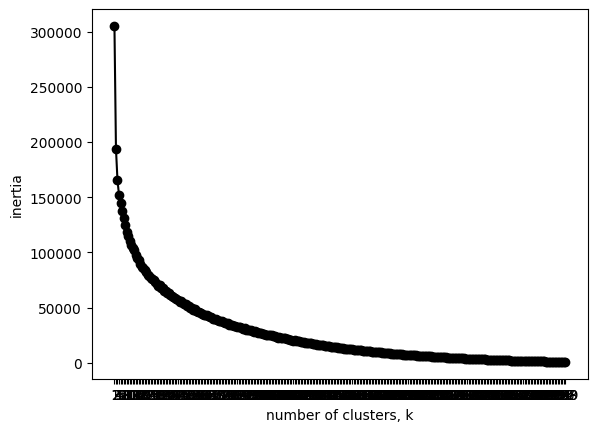

In [447]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [448]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  63


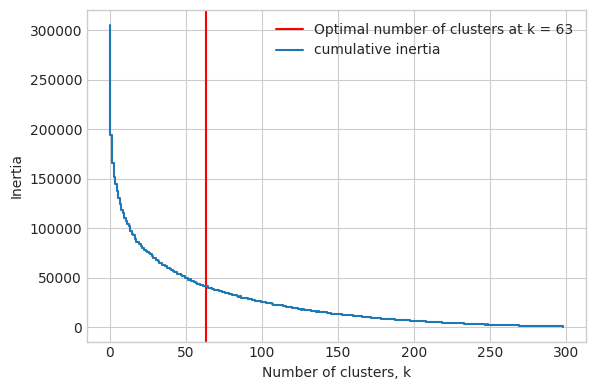

In [449]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [450]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
